In [1]:
import numpy as np
import torch
from torch import Tensor

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
D = 784
dim = D
z_dim = 784

Sphi = torch.zeros((z_dim), requires_grad=True)
St = torch.zeros((z_dim), requires_grad=True) # varience of z

Fk = torch.nn.Sequential(
    torch.nn.Linear(z_dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
    torch.nn.ReLU(),
    torch.nn.Linear(dim, dim),
    torch.nn.Sigmoid()
)

Gk1 = torch.nn.GRUCell(50, z_dim)
Gk2 = torch.nn.GRUCell(50, z_dim)

Q = torch.nn.Sequential(
    torch.nn.Linear(dim, z_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(z_dim, z_dim),
    torch.nn.Tanh(),
    torch.nn.Linear(z_dim, z_dim),
)

In [20]:
from itertools import chain
from healing_mnist import HealingMNIST

In [28]:
mnist = HealingMNIST(digits=[1])
print(mnist.train_images.shape)

size = min(len(mnist.train_images), 6000)
print(size)

X_train = Tensor(mnist.train_images[:size].reshape(size, 5, 784).astype(int))
U_train = Tensor(np.transpose(np.stack([np.sin((mnist.train_rotations[:size] / 180.) * np.pi * i) for i in range(25)] + [np.cos((mnist.train_rotations[:size] / 180.) * np.pi * i) for i in range(25)]), axes=[1, 2, 0]))

(6742, 5, 28, 28)
6000


In [32]:
T = 5
delta = 1

optimizer = torch.optim.Adam(chain(Gk.parameters(), Fk.parameters(), Q.parameters(), [Sphi, St]), lr=1e-3)
l = []
lp = []
lt = []

for k in tqdm(range(5000)):
    
    batch_size = 1
    
    batch_x = X_train[(k%(len(X_train) // batch_size))::(len(X_train) // batch_size)] 
    batch_u = U_train[(k%(len(X_train) // batch_size))::(len(X_train) // batch_size)]
    
    sample_size = 1
    
    SphiPos = torch.exp(Sphi)
    StPos = torch.exp(St)

    logp = 0
    logp += (T-1) * D * torch.prod(StPos)
    logp -= T * torch.sum(Sphi)   # sum_t torch.log(torch.prod(Sphi))
    logp += torch.prod(SphiPos)  # trace of diag
    logp += (T - 1) * torch.prod(SphiPos / StPos)  # sum^T_t=2 trace(diag(St)^-1 @ diag(Sphi))
    
    
    mu_q_t = Q(batch_x)
    
    logp += torch.mean(torch.sum((mu_q_t[:, 0, :] * mu_q_t[:, 0, :]), dim=1))
    
    # shape [sample_size, batch_size, 5, 784], random
    sample_z = mu_q_t + (SphiPos * torch.normal(torch.zeros((sample_size, batch_size, 5, z_dim)), 
                                                torch.ones((sample_size, batch_size, 5, z_dim))))
    # shape [sample_size, batch_size, 5, 784], random
    Gt_tmp = Gk1(batch_u.unsqueeze(0).repeat(sample_size, 1, 1, 1).reshape(sample_size*batch_size*5, -1), 
                 sample_z.reshape(sample_size*batch_size*5, -1))

    Gt_t_2T = Gk2(batch_u.unsqueeze(0).repeat(sample_size, 1, 1, 1).reshape(sample_size*batch_size*5, -1), 
                  Gt_tmp).reshape(sample_size, batch_size, 5, -1)

    # averaging over random sample
    logp += (1./(sample_size * batch_size))*torch.sum(((Gt_t_2T[:, :, :4, :] - mu_q_t[:, 1:, :]) * 
                                                       (Gt_t_2T[:, :, :4, :] - mu_q_t[:, 1:, :]) / StPos))
    logp *= 0.5

    p = Fk(sample_z)
    loss = torch.nn.functional.binary_cross_entropy(input=p.reshape(-1, T*784), 
                                                    target=batch_x.unsqueeze(0).repeat(sample_size, 1, 1, 1).reshape(-1, T*784))
    
    total_loss = loss + logp 
    
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    l.append(loss.data)
    lt.append(total_loss.data)
    lp.append(logp.data)

100%|██████████| 5000/5000 [09:34<00:00,  8.70it/s]


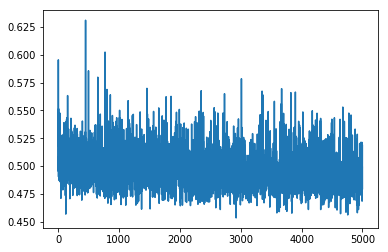

In [33]:
plt.plot(l)
# plt.ylim([-1.05, -0.95])

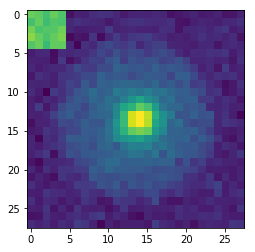

In [34]:
plt.imshow(Fk(Q(X_train[7]))[0].detach().reshape(28, 28))